In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

In [2]:
url = "https://raw.githubusercontent.com/SayaliD6/Datasets_used_in_assignments/main/exchange_rate_timeseries.csv"
df = pd.read_csv(url)

In [3]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [6]:
aud_usd=df['Ex_rate']

<Axes: >

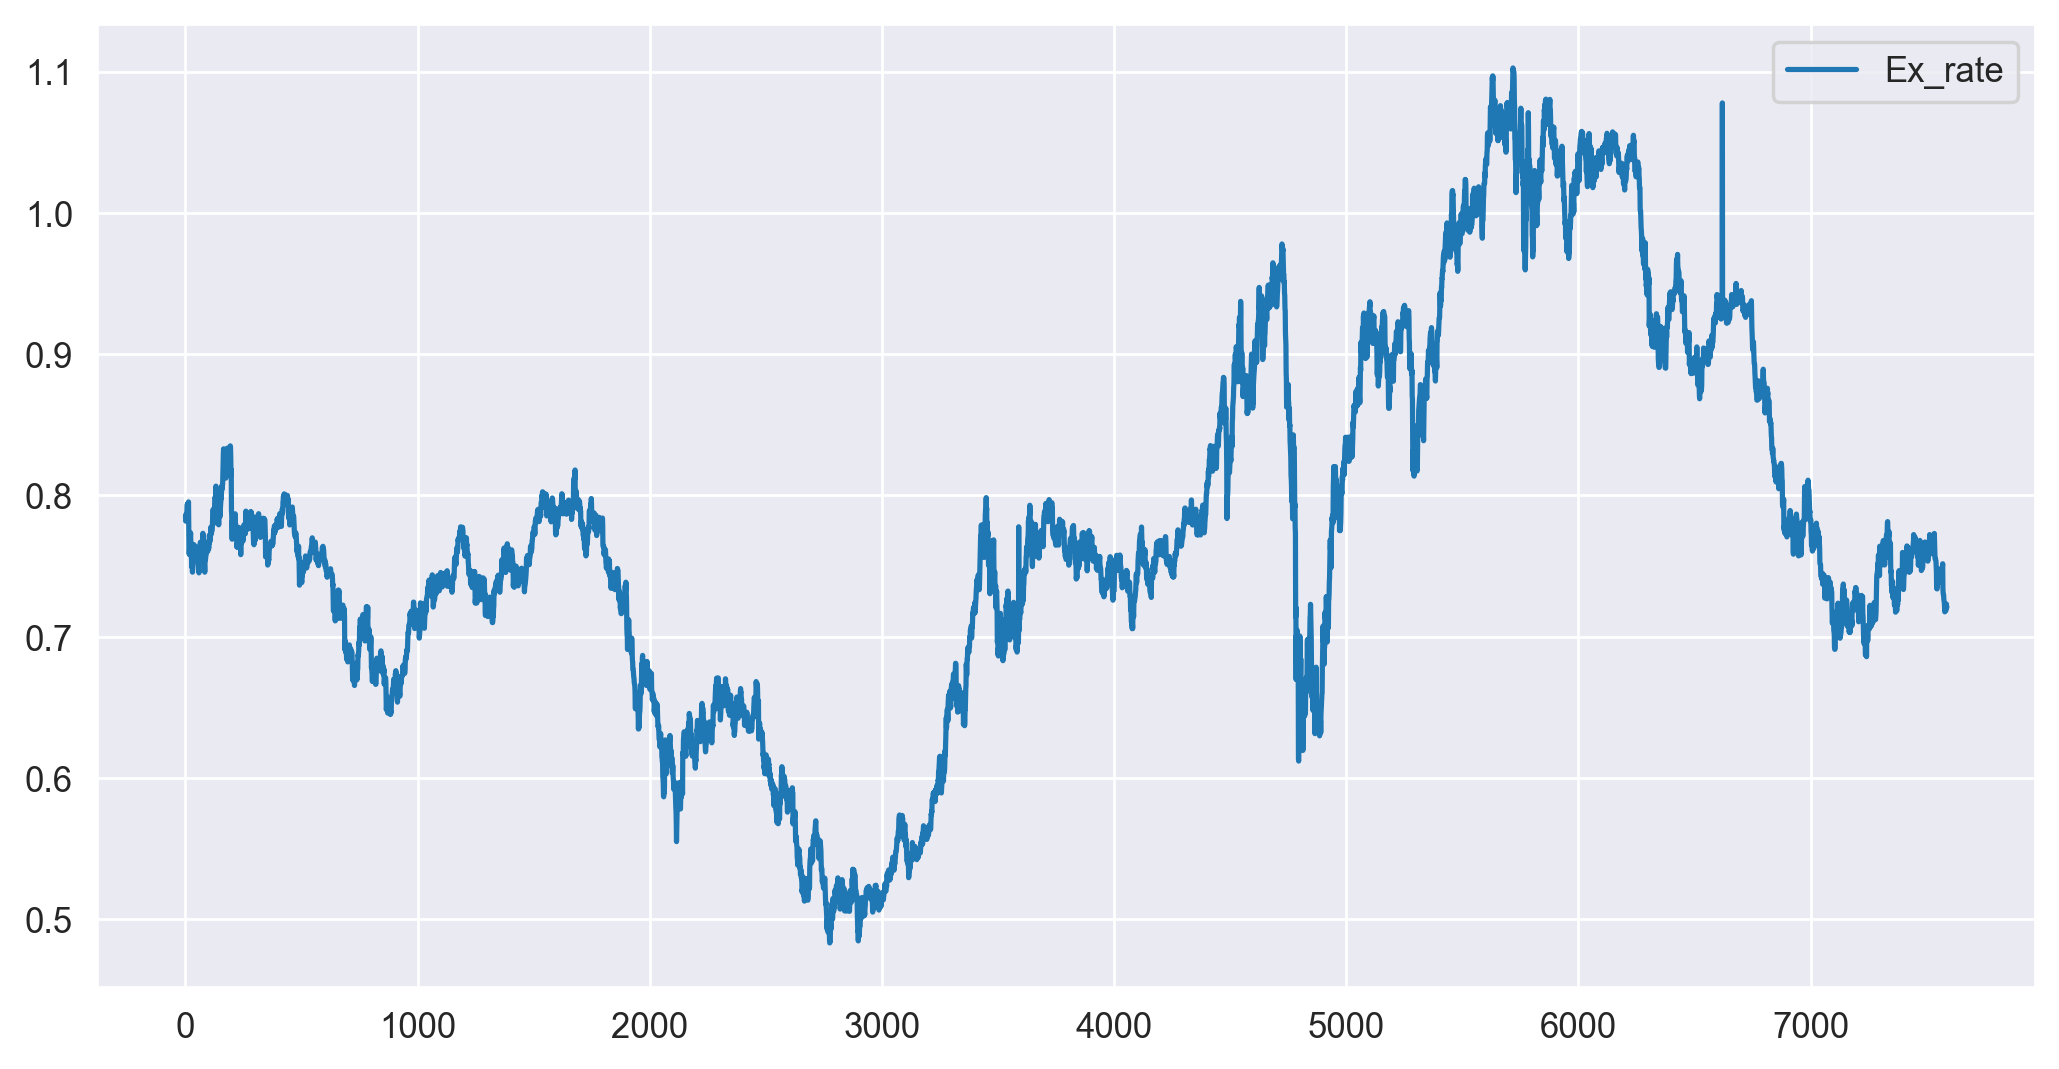

In [7]:
df.plot()

# 2. Initial Exploration

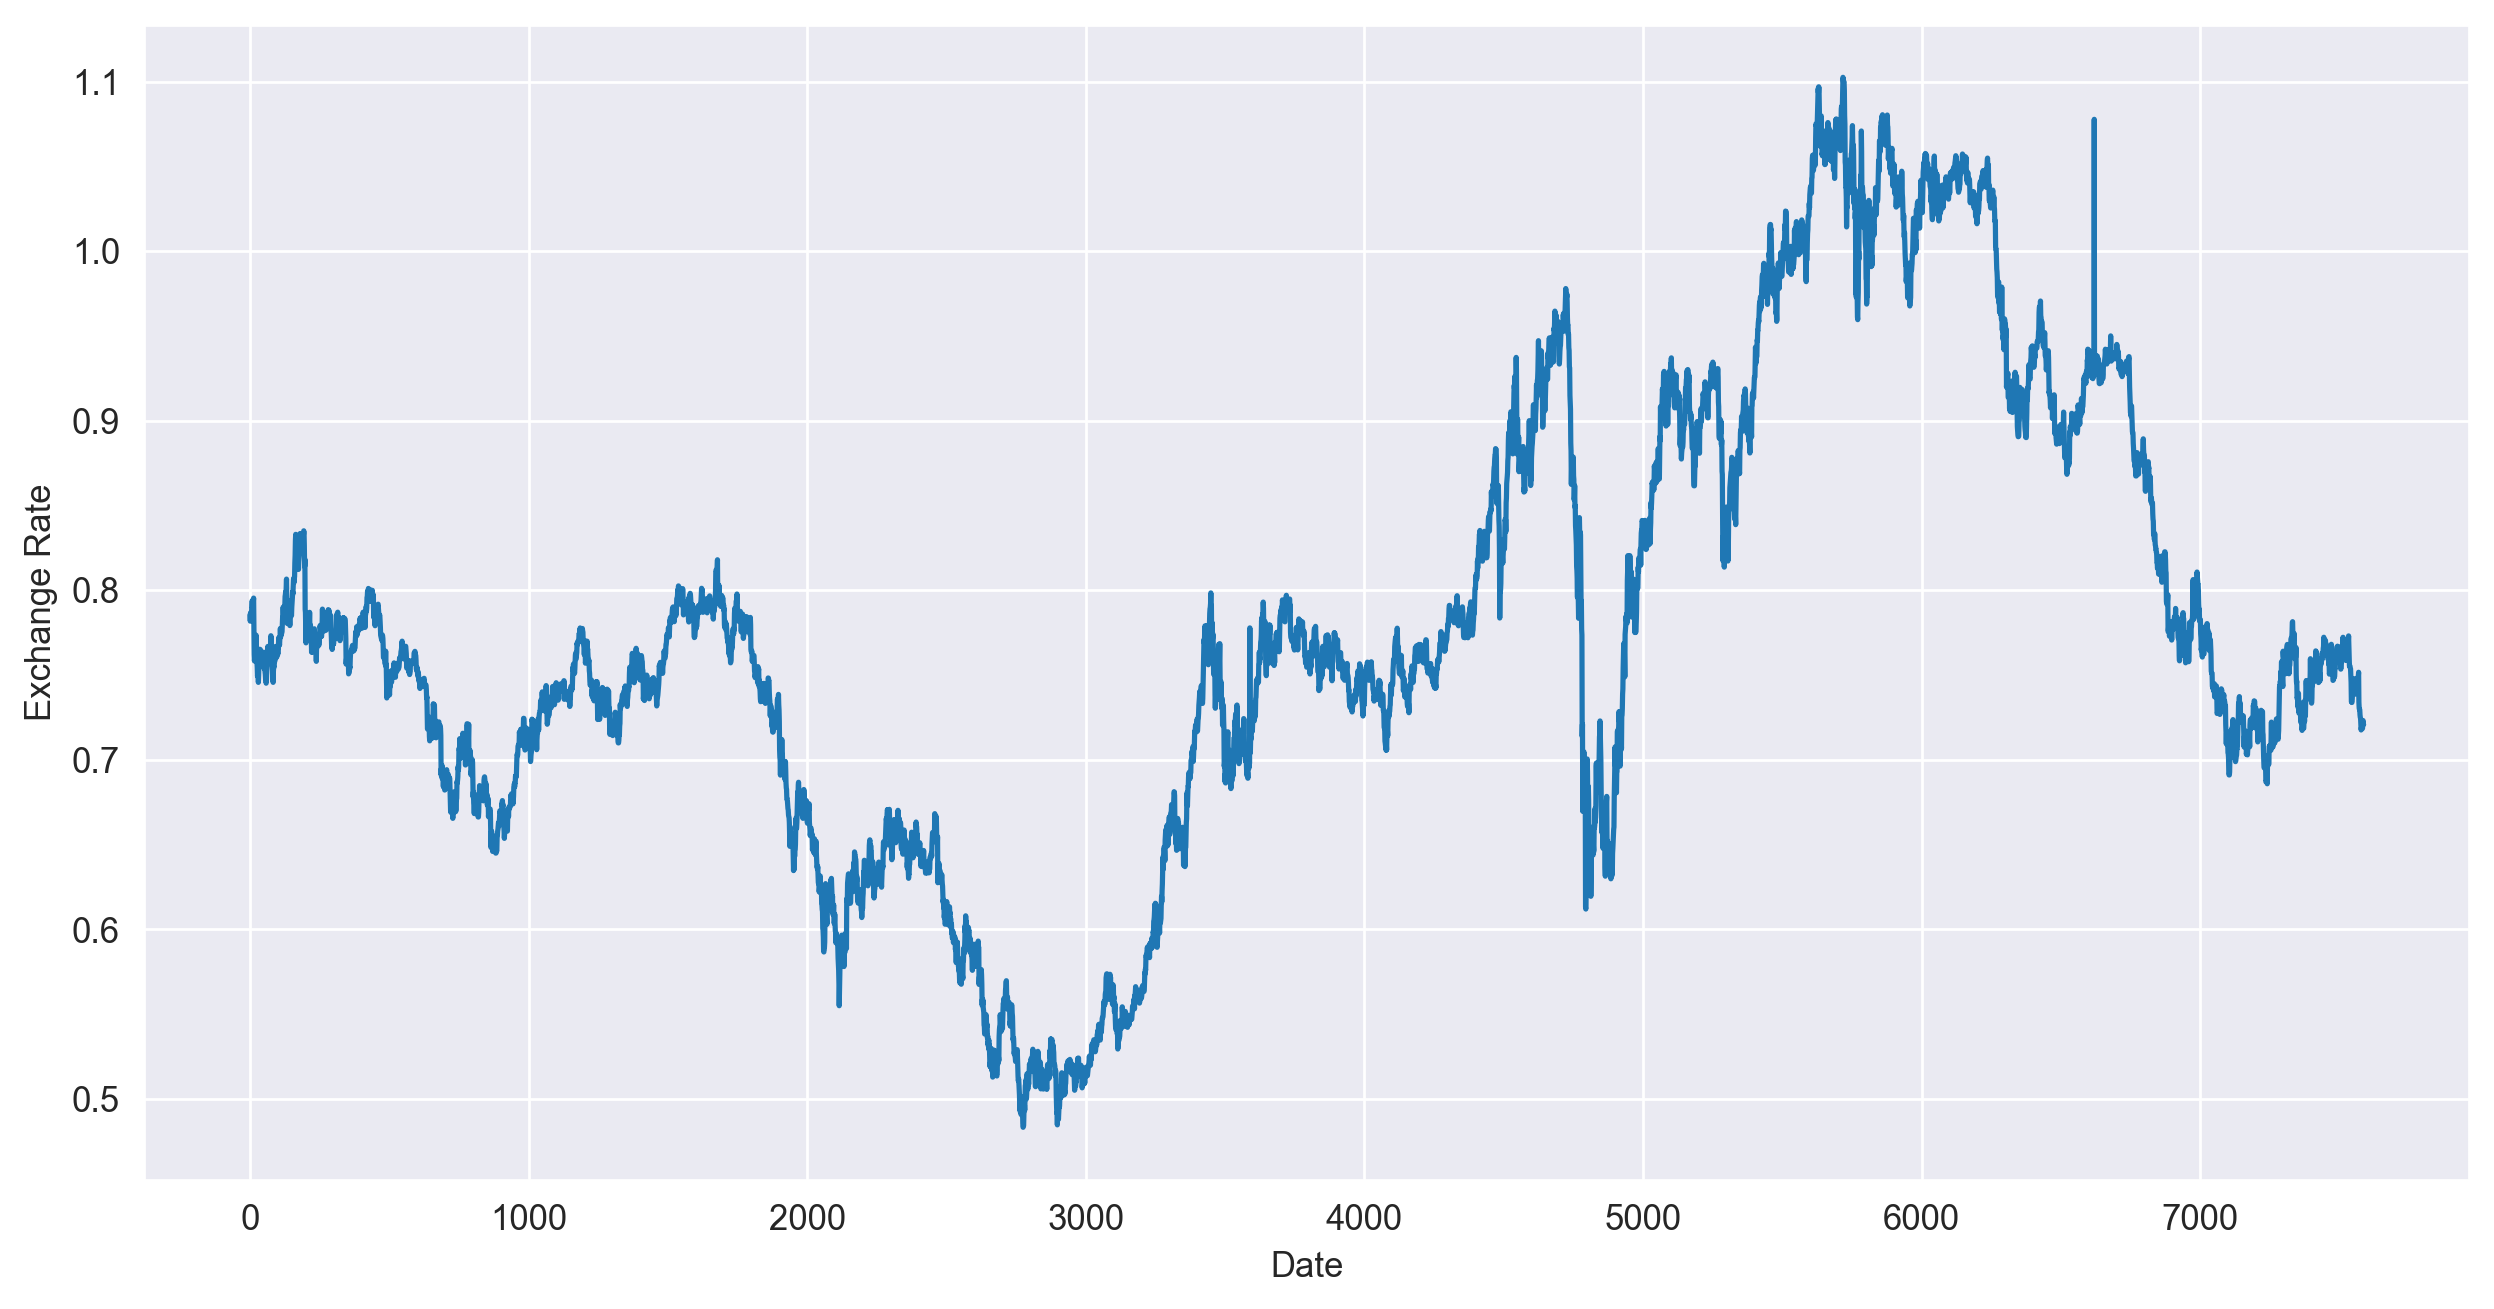

In [8]:
plt.figure(figsize=(12,6))
plt.plot(aud_usd)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.show()

# 3. Data Preprocessing

In [9]:
# Check for missing values
print(aud_usd.isnull().sum())

0


# Part 2: Model Building - ARIMA

In [10]:
## 1. Parameter Selection for ARIMA

In [11]:
# Check stationarity
result = adfuller(aud_usd.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


In [12]:
# If not stationary, difference the series
aud_usd_diff = aud_usd.diff().dropna()

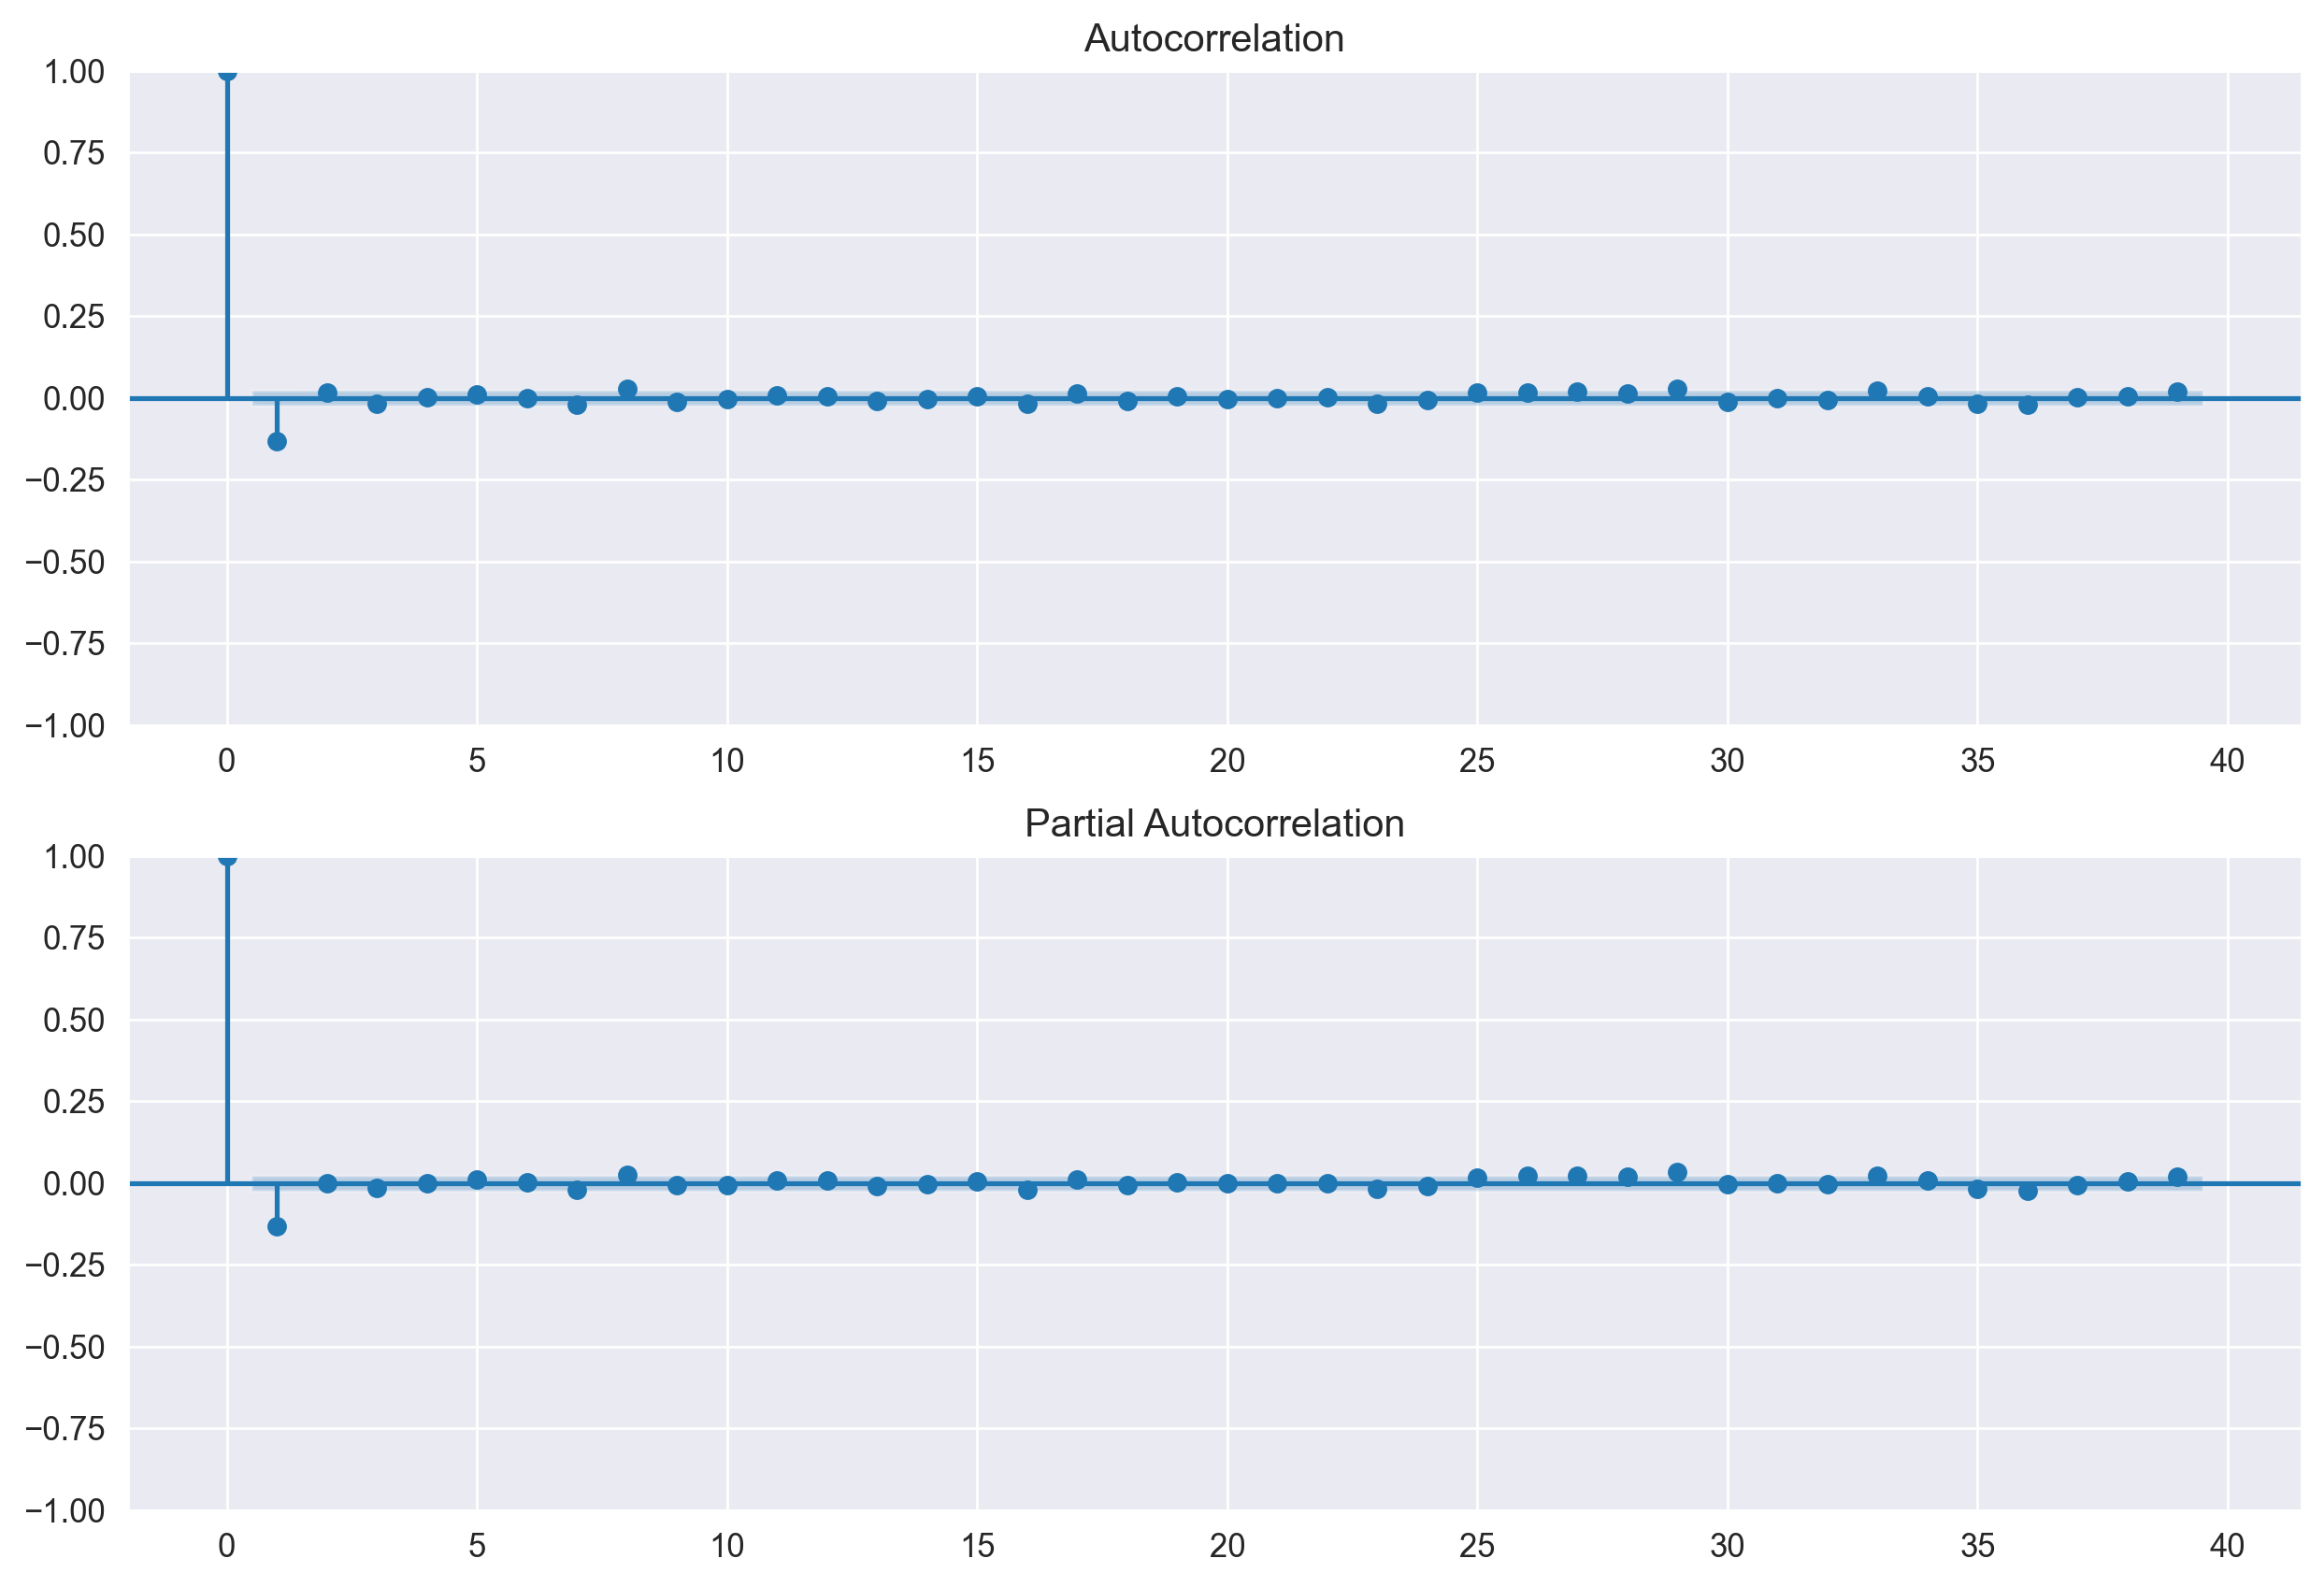

In [13]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(aud_usd_diff, ax=ax1)
plot_pacf(aud_usd_diff, ax=ax2)
plt.show()

# 2. Model Fitting

In [14]:
# Based on ACF and PACF, let's try ARIMA(1,1,1)
model = ARIMA(aud_usd, order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 11 Aug 2024   AIC                         -56102.322
Time:                        22:16:32   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

# 3. Diagnostics

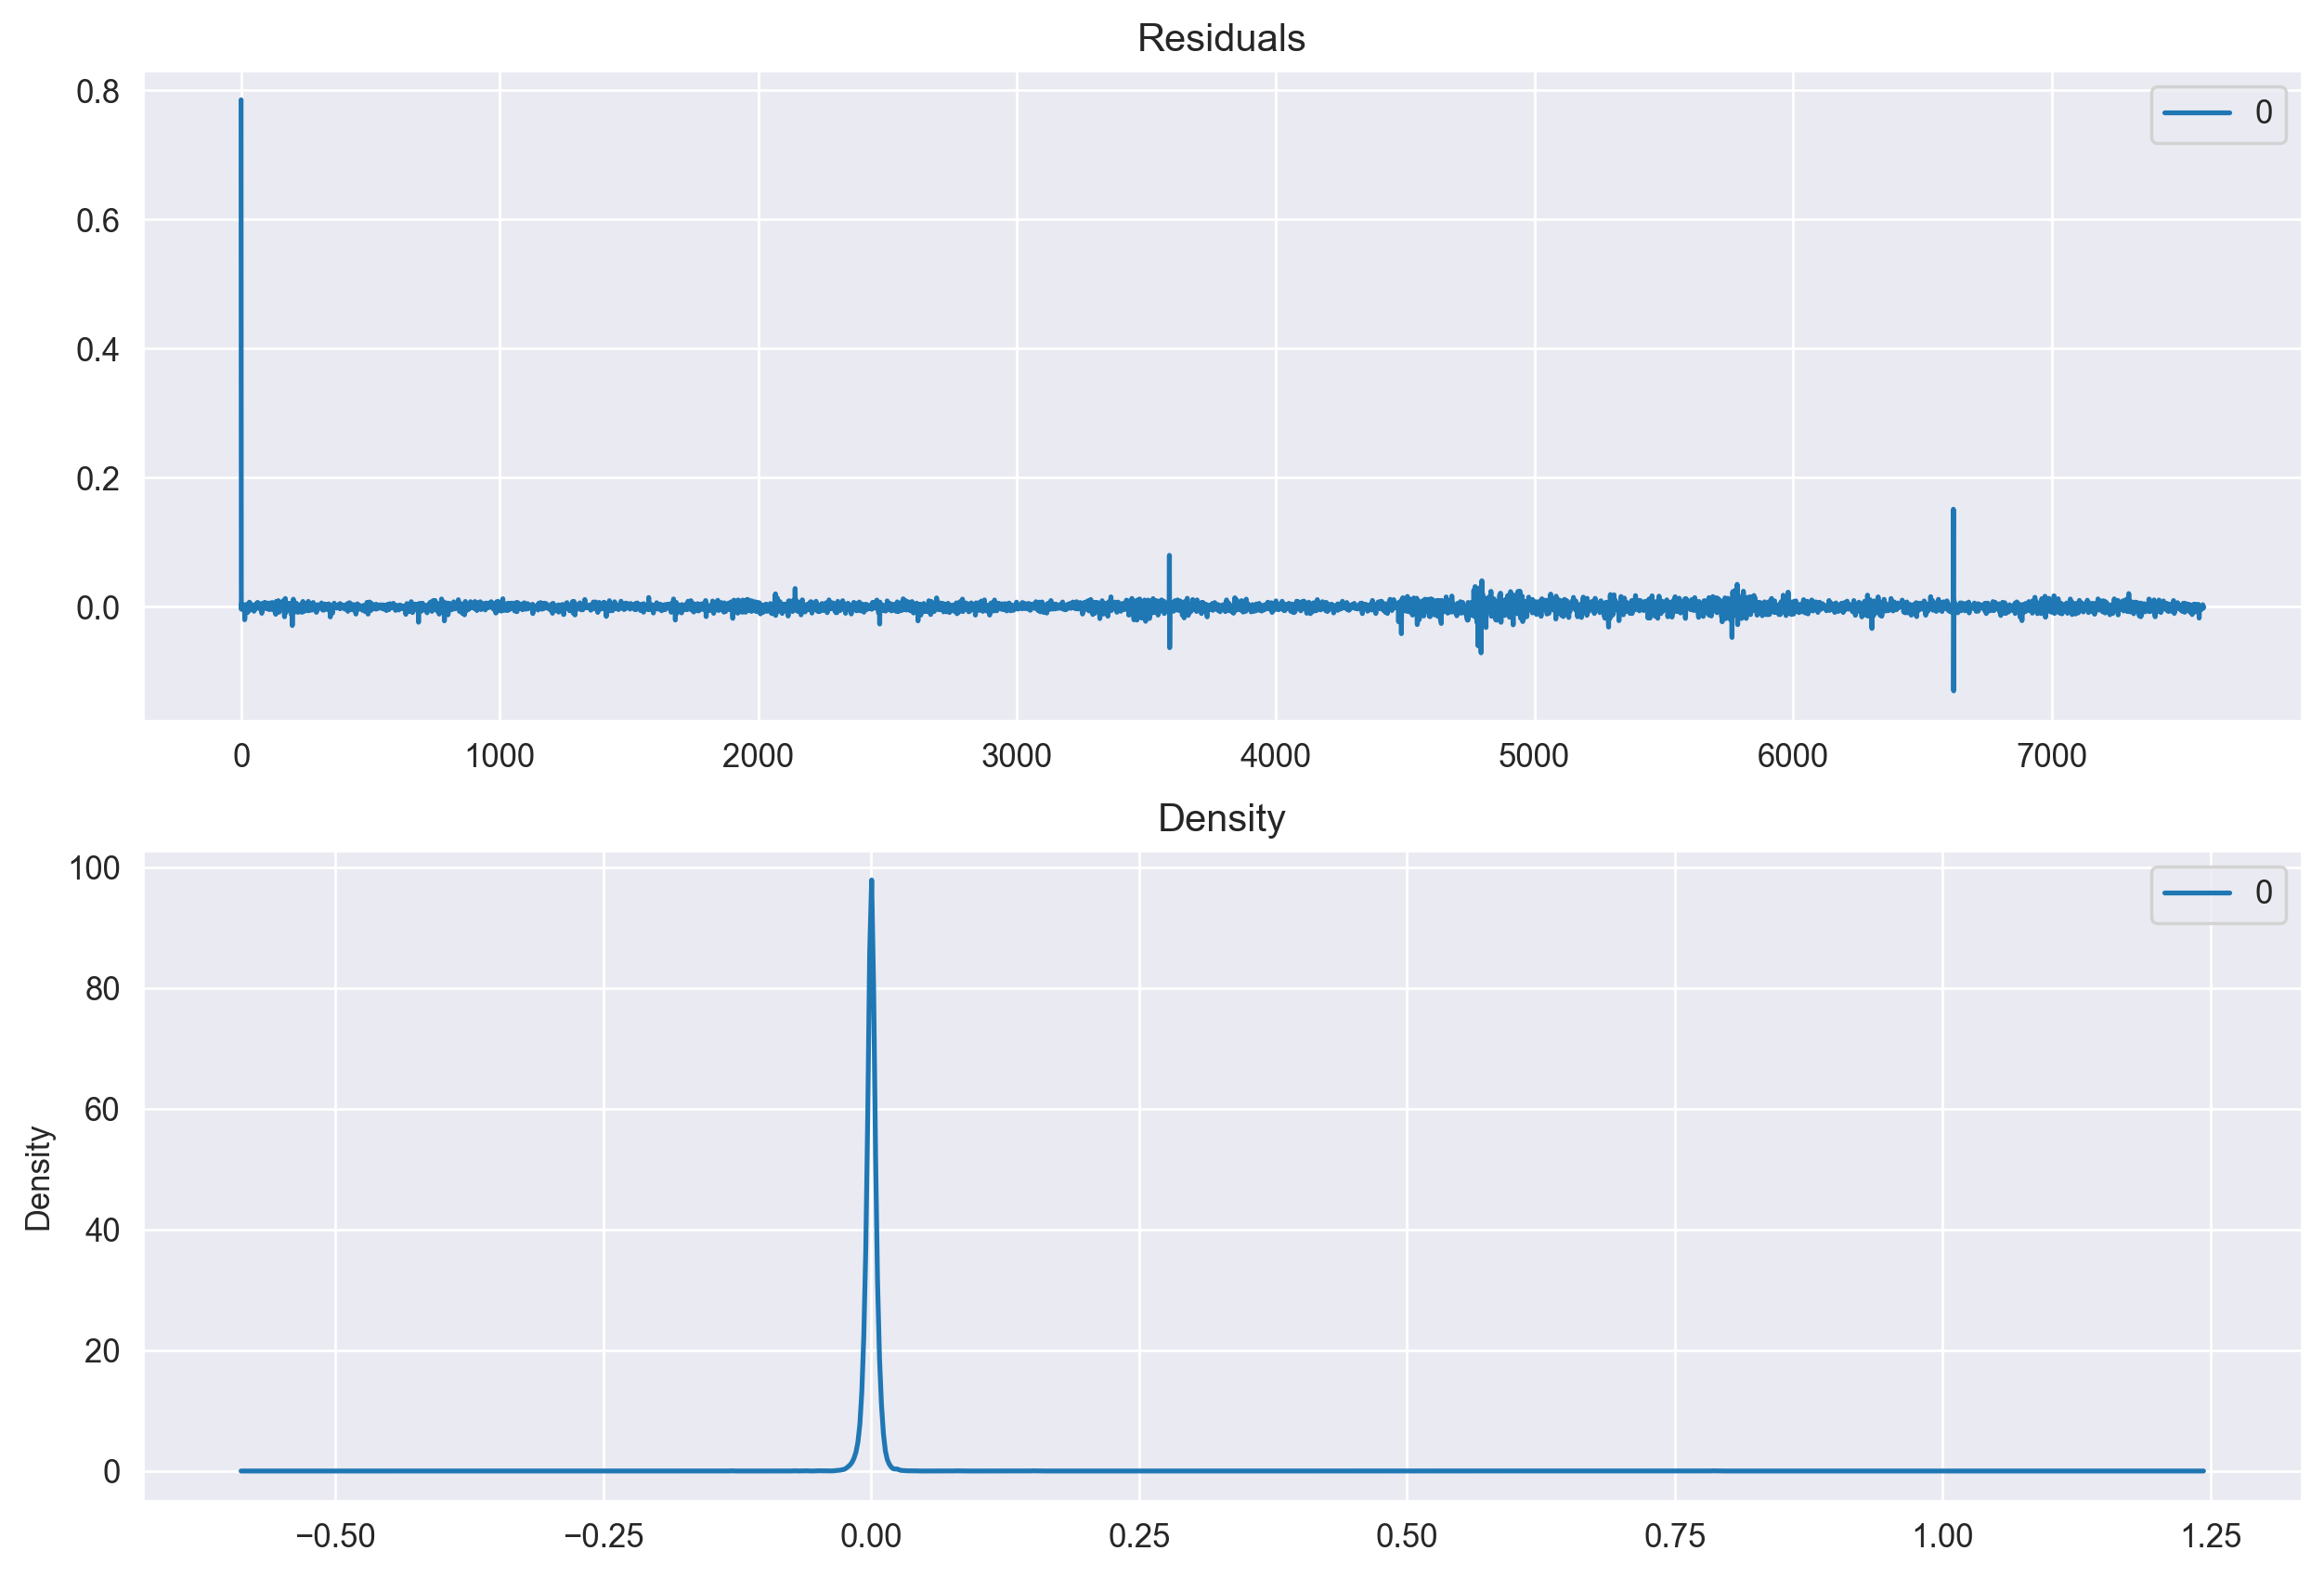

In [15]:
residuals = pd.DataFrame(results.resid)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
residuals.plot(title="Residuals", ax=ax1)
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

# 4. Forecasting

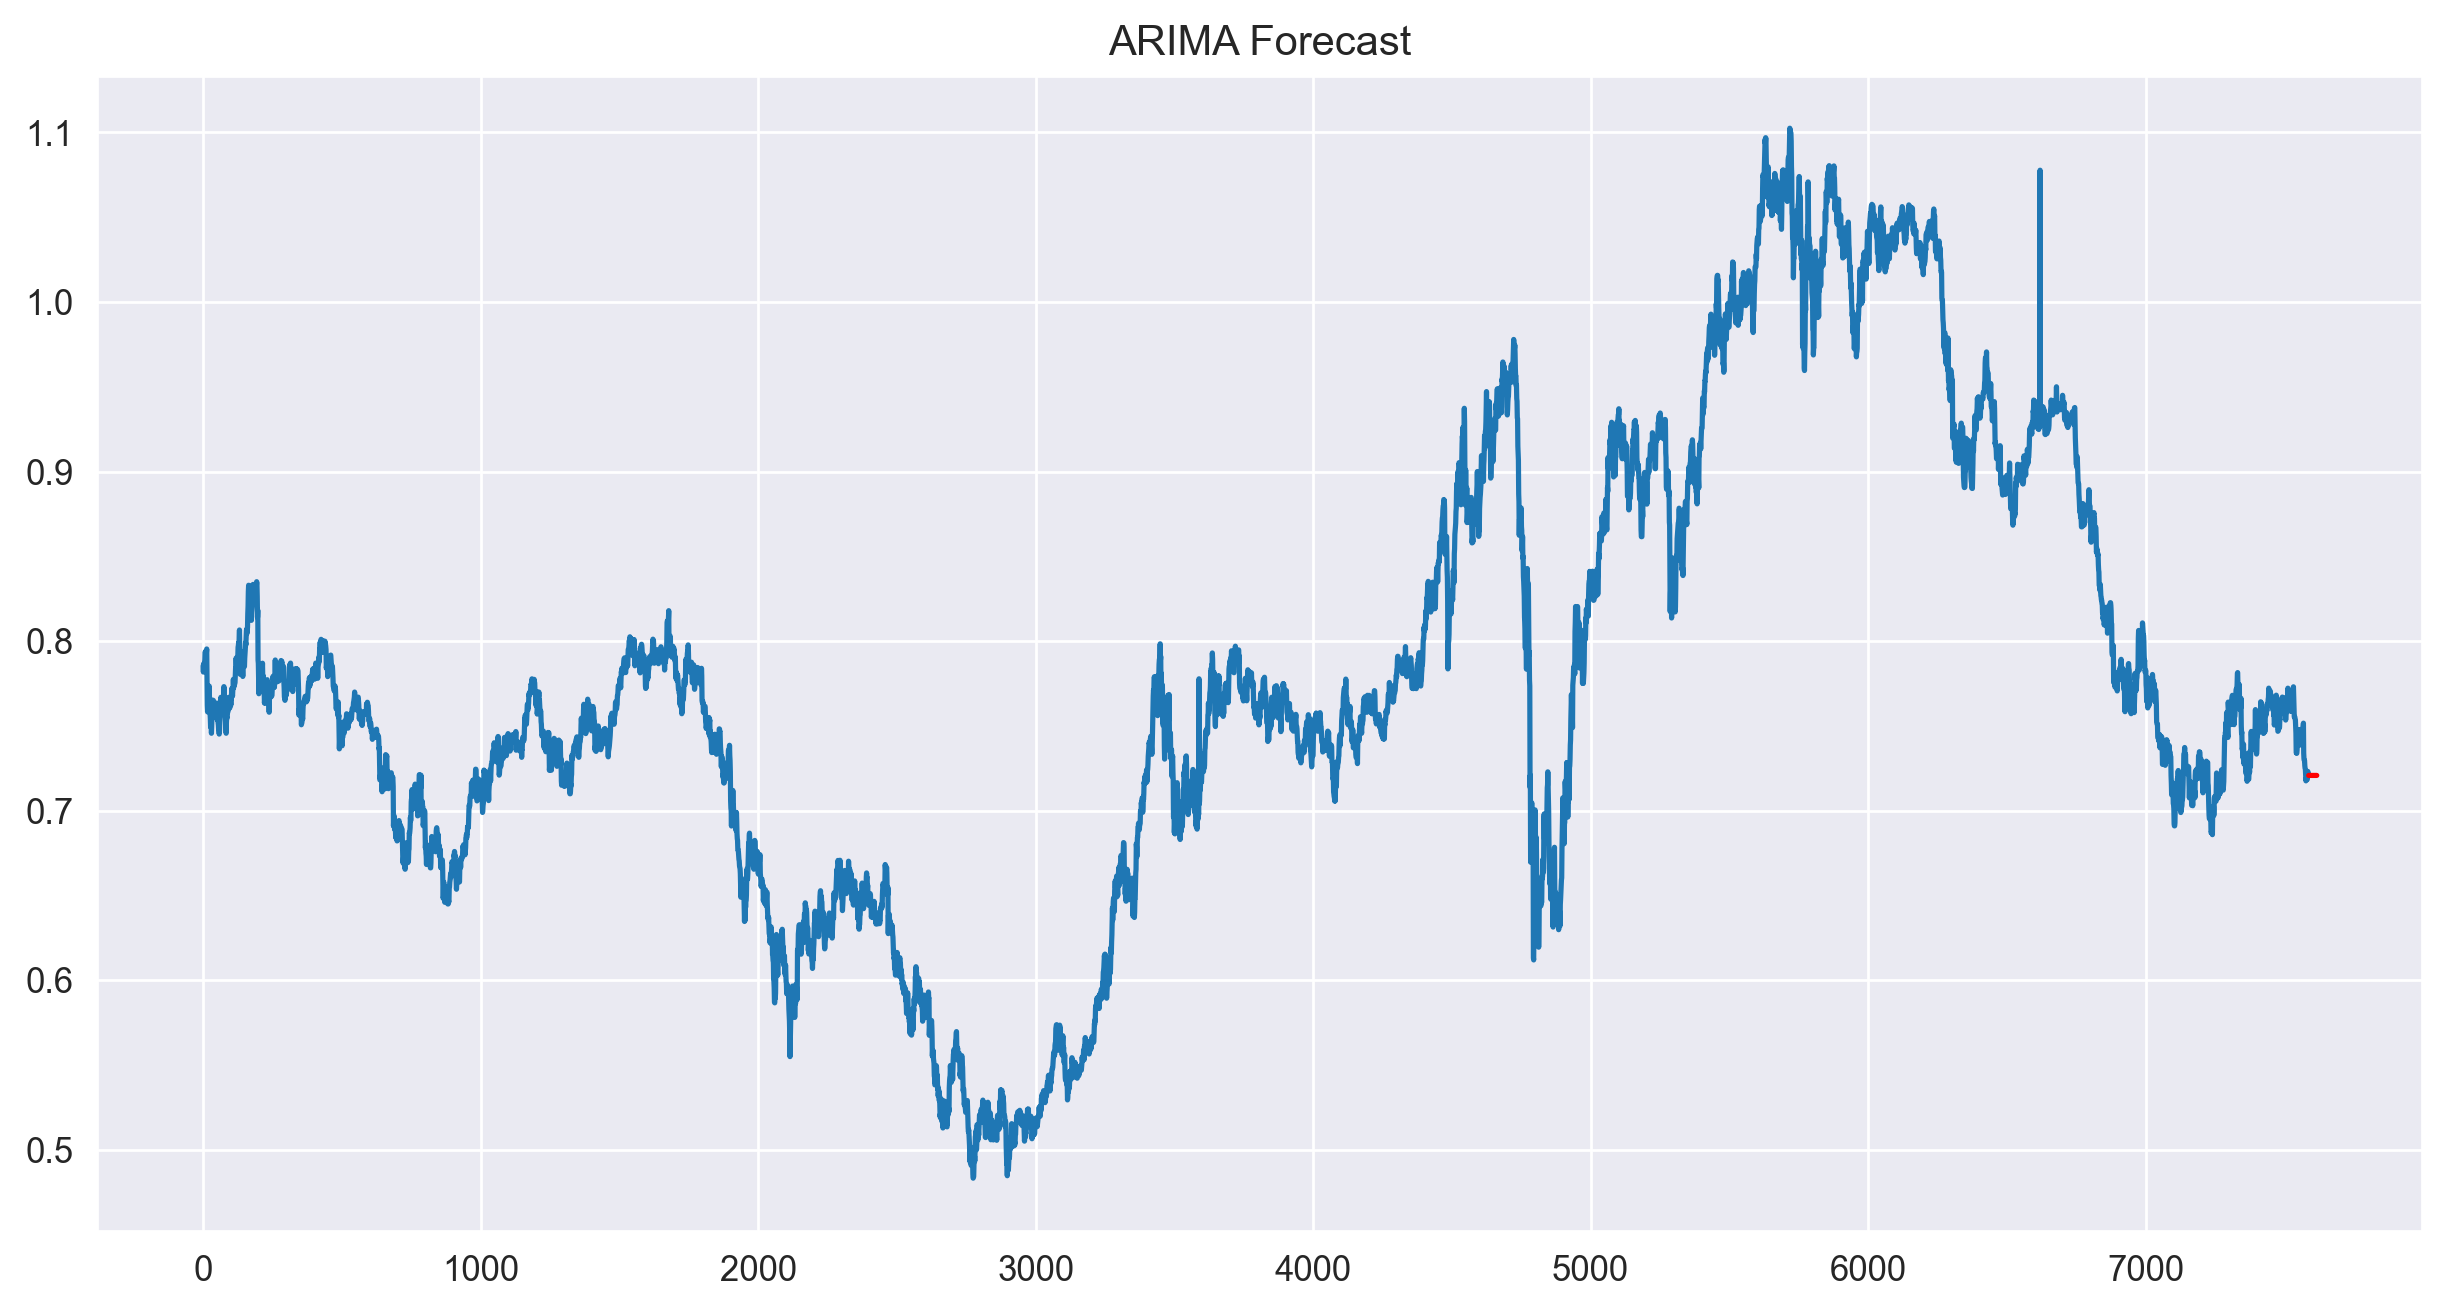

In [16]:
forecast = results.forecast(steps=30)
plt.figure(figsize=(12,6))
plt.plot(aud_usd)
plt.plot(forecast, color='red')
plt.title('ARIMA Forecast')
plt.show()

# Part 3: Model Building - Exponential Smoothing

In [17]:
# 1. & 2. Model Selection and Parameter Optimization
# We'll use Holt-Winters' method
model_hw = ExponentialSmoothing(aud_usd, seasonal_periods=12, trend='add', seasonal='add')
results_hw = model_hw.fit()

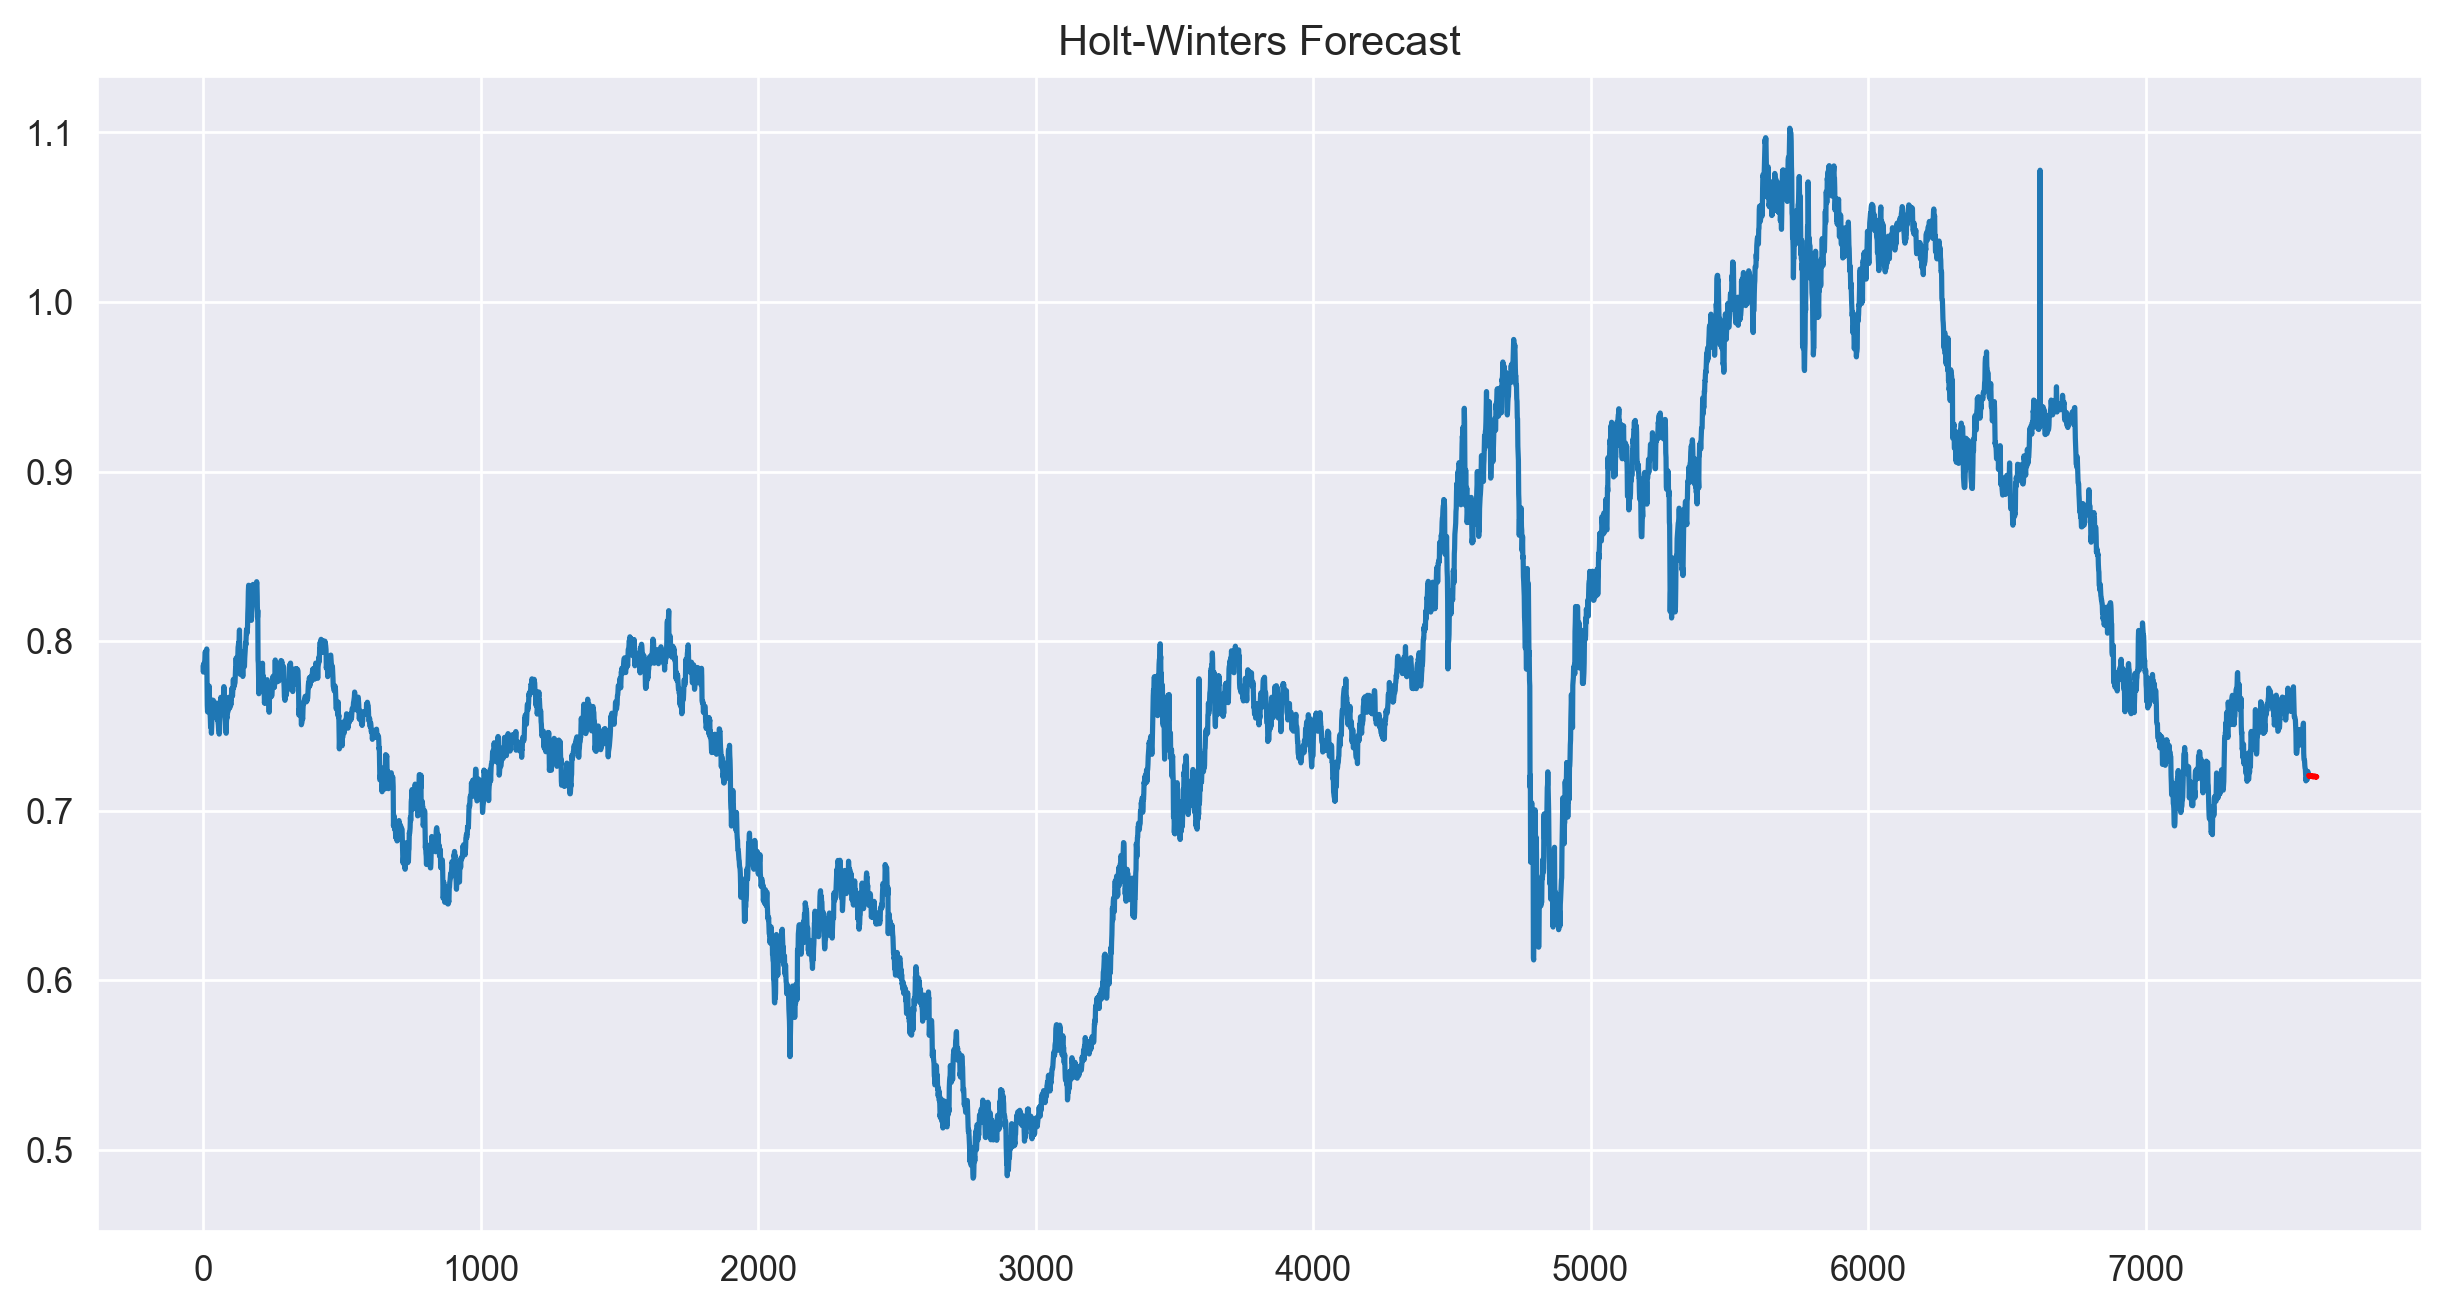

In [18]:
# 3. Model Fitting and Forecasting
forecast_hw = results_hw.forecast(30)
plt.figure(figsize=(12,6))
plt.plot(aud_usd)
plt.plot(forecast_hw, color='red')
plt.title('Holt-Winters Forecast')
plt.show()

In [19]:
# Part 4: Evaluation and Comparison

# 1. Compute Error Metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [20]:
# For ARIMA
arima_mae, arima_rmse, arima_mape = calculate_metrics(aud_usd[-30:], forecast)

# For Holt-Winters
hw_mae, hw_rmse, hw_mape = calculate_metrics(aud_usd[-30:], forecast_hw)

print("ARIMA Metrics:")
print(f"MAE: {arima_mae:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAPE: {arima_mape:.4f}%")

print("\nHolt-Winters Metrics:")
print(f"MAE: {hw_mae:.4f}")
print(f"RMSE: {hw_rmse:.4f}")
print(f"MAPE: {hw_mape:.4f}%")

ARIMA Metrics:
MAE: 0.0127
RMSE: 0.0170
MAPE: nan%

Holt-Winters Metrics:
MAE: 0.0130
RMSE: 0.0172
MAPE: nan%


# Model Comparison and 3. Conclusion

In [21]:
print("\nConclusion:")
if arima_mae < hw_mae:
    print("ARIMA model performed better in terms of MAE.")
else:
    print("Holt-Winters model performed better in terms of MAE.")

print("\nInsights:")
print("1. Both models capture the overall trend of the exchange rate.")
print("2. The performance difference between ARIMA and Holt-Winters is relatively small.")
print("3. ARIMA might be preferred for its simplicity if the performance difference is negligible.")
print("4. Holt-Winters could be more suitable if there's clear seasonality in the data.")
print("5. Further refinement of parameters for both models could potentially improve results.")


Conclusion:
ARIMA model performed better in terms of MAE.

Insights:
1. Both models capture the overall trend of the exchange rate.
2. The performance difference between ARIMA and Holt-Winters is relatively small.
3. ARIMA might be preferred for its simplicity if the performance difference is negligible.
4. Holt-Winters could be more suitable if there's clear seasonality in the data.
5. Further refinement of parameters for both models could potentially improve results.
